<a href="https://colab.research.google.com/github/saumya0303/audio_adversarial_examples/blob/master/tensorflw_stft_plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#imports
import scipy.io.wavfile as wav
import numpy as np
from scipy.fftpack import fft
from scipy.fftpack import ifft
from scipy import signal
import scipy
import librosa
from matplotlib import pyplot as plt
import tensorflow as tf

In [0]:
def compute_PSD_matrix(audio, window_size):
    """
	First, perform STFT.
	Then, compute the PSD.
	Last, normalize PSD.
    """

    win = np.sqrt(8.0 / 3.) * librosa.core.stft(audio, center=False)
    print(np.shape(librosa.core.stft(audio, center=False)))
    # print("librosa")
    # print(len(librosa.core.stft(audio, center=False)))
    z = abs(win / window_size)
    psd_max = np.max(z * z)
    psd = 10 * np.log10(z * z + 0.0000000000000000001)
    PSD = 96 - np.max(psd) + psd
    z=z.flatten()
    psd_flattened = PSD.flatten()
    return PSD, psd_max

In [0]:
def Bark(f):
    """returns the bark-scale value for input frequency f (in Hz)"""
    return 13 * np.arctan(0.00076 * f) + 3.5 * np.arctan(pow(f / 7500.0, 2))

In [0]:
def quiet(f):
    """returns threshold in quiet measured in SPL at frequency f with an offset 12(in Hz)"""
    thresh = 3.64 * pow(f * 0.001, -0.8) - 6.5 * np.exp(-0.6 * pow(0.001 * f - 3.3, 2)) + 0.001 * pow(0.001 * f, 4) - 12
    return thresh

In [0]:
def two_slops(bark_psd, delta_TM, bark_maskee):
    """
	returns the masking threshold for each masker using two slopes as the spread function
    """
    Ts = []
    for tone_mask in range(bark_psd.shape[0]):
        bark_masker = bark_psd[tone_mask, 0]
        dz = bark_maskee - bark_masker
        zero_index = np.argmax(dz > 0)
        sf = np.zeros(len(dz))
        sf[:zero_index] = 27 * dz[:zero_index]
        sf[zero_index:] = (-27 + 0.37 * max(bark_psd[tone_mask, 1] - 40, 0)) * dz[zero_index:]
        T = bark_psd[tone_mask, 1] + delta_TM[tone_mask] + sf
        Ts.append(T)
    return Ts

In [0]:
def compute_th(PSD, barks, ATH, freqs,freq_stft):
    """
    returns the global masking threshold
    """
    # Identification of tonal maskers
    # find the index of maskers that are the local maxima
    length = len(PSD)
    masker_index = signal.argrelextrema(PSD, np.greater)[0]




    # delete the boundary of maskers for smoothing
    if 0 in masker_index:
        masker_index = np.delete(0)
    if length - 1 in masker_index:
        masker_index = np.delete(length - 1)
    num_local_max = len(masker_index)

    #compute a matrix which contains value 0 for non tonal frequencies
    for i in range(1025):
        if i not in masker_index:
            freq_stft[i]=0
        else:
          freq_stft[i]=1


    # treat all the maskers as tonal (conservative way)
    # smooth the PSD
    p_k = pow(10, PSD[masker_index] / 10.)
    p_k_prev = pow(10, PSD[masker_index - 1] / 10.)
    p_k_post = pow(10, PSD[masker_index + 1] / 10.)
    P_TM = 10 * np.log10(p_k_prev + p_k + p_k_post)

    # bark_psd: the first column bark, the second column: P_TM, the third column: the index of points
    _BARK = 0
    _PSD = 1
    _INDEX = 2
    #num_local maxima is number of maskers we get
    bark_psd = np.zeros([num_local_max, 3])
    #barks is an array containing frequwncies in bark
    bark_psd[:, _BARK] = barks[masker_index]
    bark_psd[:, _PSD] = P_TM
    bark_psd[:, _INDEX] = masker_index

    # delete the masker that doesn't have the highest PSD within 0.5 Bark around its frequency
    for i in range(num_local_max):
        next = i + 1
        if next >= bark_psd.shape[0]:
            break

        while bark_psd[next, _BARK] - bark_psd[i, _BARK] < 0.5:
            # masker must be higher than quiet threshold
            if quiet(freqs[int(bark_psd[i, _INDEX])]) > bark_psd[i, _PSD]:
                bark_psd = np.delete(bark_psd, (i), axis=0)
            if next == bark_psd.shape[0]:
                break
            #axis=0 is the direction along the rows
            if bark_psd[i, _PSD] < bark_psd[next, _PSD]:
                bark_psd = np.delete(bark_psd, (i), axis=0)
            else:
                bark_psd = np.delete(bark_psd, (next), axis=0)
            if next == bark_psd.shape[0]:
                break

                # compute the individual masking threshold
    delta_TM = 1 * (-6.025 - 0.275 * bark_psd[:, 0])#delta_tm is the masking frequency in barc scale
    Ts = two_slops(bark_psd, delta_TM, barks)
    # print("individual masking threshold").
   
    Ts = np.array(Ts)

    #ax.plot(masker_index,P_TM.flatten()[0:num_local_max],'y--')
    # print("Ts")
    # print(len(Ts))

    # compute the global masking threshold
    theta_x = 10 * np.log10(np.sum(pow(10, Ts / 10.), axis=0) + pow(10, ATH / 10.))
   
    return theta_x


(1025, 134)
(1025, 134)


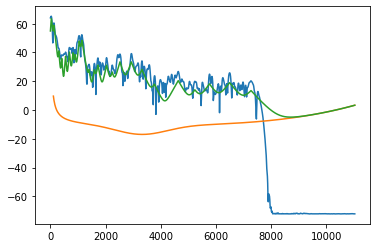

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 ...
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j ... 1.+0.j 1.+0.j 1.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]]
Tensor("Mul_16:0", shape=(134, 1025), dtype=complex64)
[[-0.0000000e+00+0.0000000e+00j  0.0000000e+00+0.0000000e+00j
   0.0000000e+00+0.0000000e+00j ...  0.0000000e+00+0.0000000e+00j
   0.0000000e+00+0.0000000e+00j -0.0000000e+00+0.0000000e+00j]
 [-0.0000000e+00+0.0000000e+00j  0.0000000e+00+0.0000000e+00j
   0.0000000e+00-0.0000000e+00j ... -0.0000000e+00+0.0000000e+00j
   0.0000000e+00+0.0000000e+00j -0.0000000e+00+0.0000000e+00j]
 [-0.0000000e+00+0.0000000e+00j -0.0000000e+00+0.0000000e+00j
   0.0000000e+00+0.0000000e+00j ...  0.000000

In [0]:
#generate threshold
def generate_th(audio, fs, window_size=2048):
    """
	returns the masking threshold theta_xs and the max psd of the audio
    """
    PSD, psd_max = compute_PSD_matrix(audio, window_size)
    freqs = librosa.core.fft_frequencies(fs, window_size)
    freq_stft=librosa.core.stft(audio, center=False, hop_length=512, win_length=2048, window='hann')
    print(np.shape(freq_stft))
    psd_flattened = PSD.flatten()
    barks = Bark(freqs)


    # compute the quiet threshold
    ATH = np.zeros(len(barks)) - np.inf
    bark_ind = np.argmax(barks > 1)
    ATH[bark_ind:] = quiet(freqs[bark_ind:])

    # compute the global masking threshold theta_xs
    theta_xs = []
    # print("psdfunction")
    # print(PSD.shape[1])
    # compute the global masking threshold in each window
    for i in range(PSD.shape[1]):
        # print("psd ata a step")
        # print(PSD[:, i])
        # print(len(PSD[:, i]))
        theta_xs.append(compute_th(PSD[:, i], barks, ATH, freqs,freq_stft[:,i]))
        # print("compute_th")
        # print(PSD[:, i], barks, ATH, freqs)
        # print(len(compute_th(PSD[:, i], barks, ATH, freqs)))
    theta_xs = np.array(theta_xs)
    plt.plot(freqs,PSD[:,0])
    plt.plot(freqs,ATH)
    plt.plot(freqs,theta_xs[0])
    plt.show()

    data , sampling_rate = librosa.load('/content/drive/My Drive/sample-000000.wav')
# for use in tensorflow
    data_tensor = tf.convert_to_tensor( data )
    a=tf.signal.stft(
    data_tensor, 2048, 512, fft_length=None,
    window_fn=tf.signal.hann_window, pad_end=False, name=None
)
    print(freq_stft.real)
    x=tf.math.multiply(a,tf.transpose(freq_stft))
    print(freq_stft)
    print(x)
    p=tf.signal.inverse_stft(
    x, 2048, 512, fft_length=None,
    window_fn=tf.signal.hann_window, name=None
)
    signal_n = p.eval(session=tf.compat.v1.Session())
    
    res = x.eval(session=tf.compat.v1.Session())
    print(res)

    librosa.output.write_wav('/content/sample_data/sample_data3.wav', signal_n, sampling_rate)
    print(np.shape(theta_xs))
    
    return theta_xs, psd_max



audios = []
lengths = []
th_batch = []
psd_max_batch = []
for i in range(1):
    sample_rate_np, audio_temp = wav.read('/content/drive/My Drive/sample-000000.wav')
    if max(audio_temp) < 1:
        audio_np = audio_temp * 32768
    else:
        audio_np = audio_temp

    length = len(audio_np)

    audios.append(audio_np)
    lengths.append(length)
max_length = max(lengths)

# pad the input audio
audios_np = np.zeros([1, max_length])

for i in range(1):
    audio_float = audios[i].astype(float)
    data2 , sampling_rate2 = librosa.load('/content/drive/My Drive/sample-000000.wav')
    th, psd_max = generate_th(data2, sampling_rate2, 2048)
 

In [0]:

print(a)

Tensor("stft_3/rfft:0", shape=(134, 1025), dtype=complex64)
